# TUTORIAL: Class Model and ensemble forecast

* [How to use the class Model in "src.models_physical"](#first)
    * [Model initialization](#second)
    * [Model forecast](#third)
* [Ensemble of class Model](#fourth)
    * [Initialize ensemble](#fifth)
    * [Forecast ensemble](#sixth)
* [Introduction to create_ensemble function in "src.create"](#seventh)


# How to use the class Model in "src.models_physical" <a class="anchor" id="first"></a>

### 1. Initialise a model from models_physical using the defaults parameters  <a class="anchor" id="second"></a>
The available models are:
* Lorenz63
* Rijke
* Annular
* Van der Pol

In [1]:
from src.models_physical import *

case = Lorenz63()  # If no arguments, the class is initialized with the default parameters


### 2. Forecast the model as a single case  <a class="anchor" id="third"></a>

First, save the history of the class and then get the observable history. 
Note that, although in the Lorenz case the observables are equivalent to the state variables, in more complex models such as the Rijke tube model, the observables are a function of the state variables.

In [2]:
import time

Nt_forecast = int(10 * case.t_transient / case.dt)

t1 = time.time()
state, t_ = case.time_integrate(Nt_forecast)
case.update_history(state, t_)

single_case_time = time.time() - t1
print('Elapsed time = ', str(single_case_time))



Elapsed time =  0.16902494430541992


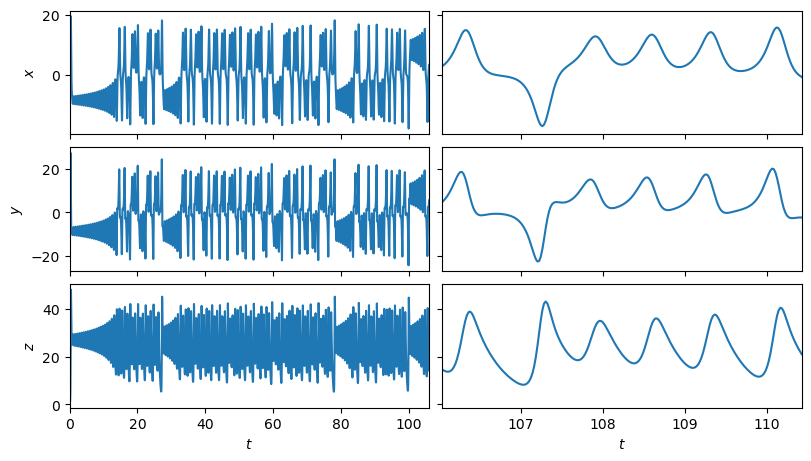

In [3]:
import matplotlib.pyplot as plt

t_h = case.hist_t
y = case.get_observable_hist() # history of the model observables 
lbl = case.obs_labels

# Plot the time evolution of the observables
t_zoom = int(case.t_CR / case.dt)

fig = plt.figure(figsize=(8, 4.5), layout="constrained")
axs = fig.subplots(case.Nq, 2, sharey='row', sharex='col')

for ii, ax in enumerate(axs):
    ax[0].plot(t_h, y[:, ii])
    ax[1].plot(t_h[-t_zoom:], y[-t_zoom:, ii])
    ax[0].set(ylabel=lbl[ii])
    if ii == case.Nq-1:
        ax[0].set(xlabel='$t$', xlim=[t_h[0], t_h[-t_zoom]])
        ax[1].set(xlabel='$t$', xlim=[t_h[-t_zoom], t_h[-1]])

# Ensemble of class Model <a class="anchor" id="fourth"></a>

### 1. Initialize ensemble <a class="anchor" id="fifth"></a>

In [4]:
ensemble = case.copy()

m = 100
# Generate ensemble
ensemble.init_ensemble(m=m, 
                       std_psi=0.1, 
                       est_a=case.params[:2], # Select the ensemble varying parameters
                       std_a=0.4,  # the parameters uncertainty can also be defined individually in a dictionary
                       alpha_distr='uniform'
                      )


### 2. Forecast ensemble <a class="anchor" id="sixth"></a>
The Model time_integrate function is parallelized to save computation time. We compare the ensemble forecast with a for loop forecast. 


In [5]:
t1 = time.time()
state, t_ = ensemble.time_integrate(Nt=Nt_forecast)
ensemble.update_history(state, t_, reset=True) # add the forecast to the model history
ensemble_case_time = time.time() - t1
print(f'Elapsed ensemble time = {ensemble_case_time}')

Elapsed ensemble time = 1.6885080337524414


In [6]:
ensemble.hist[0].shape

(5, 100)

In [7]:
t1 = time.time()
psi0 = ensemble.hist[0]
alpha0 = ensemble.alpha.copy()
state_for, t_for = [], []
for mi in range(ensemble.m):
    case.update_history(psi0[:, [mi]], reset=True)
    out = case.time_integrate(Nt=Nt_forecast)
    state_for.append(out[0])
    t_for.append(out[1])
ensemble_for_time = time.time() - t1

print(f'Elapsed ensemble for loop time = {ensemble_for_time} >> {ensemble_case_time}.')

Elapsed ensemble for loop time = 14.91102910041809 >> 1.6885080337524414.


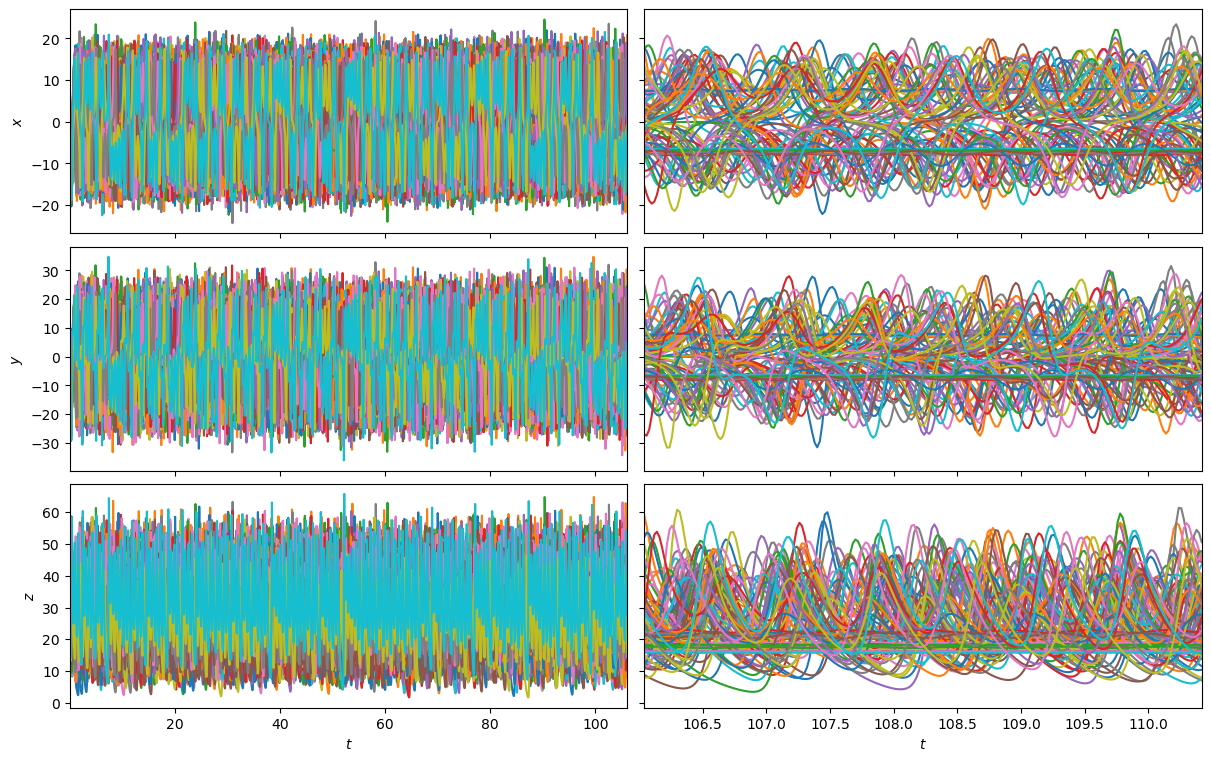

In [8]:
# history of the model observables 
t_h = ensemble.hist_t
y = ensemble.get_observable_hist()
lbl = ensemble.obs_labels

# Plot the time evolution of the observables
t_zoom = int(case.t_CR / case.dt)

fig = plt.figure(figsize=(12, 7.5), layout="constrained")
axs = fig.subplots(case.Nq, 2, sharey='row', sharex='col')

for ii, ax in enumerate(axs):
    ax[0].plot(t_h, y[:, ii])
    ax[1].plot(t_h[-t_zoom:], y[-t_zoom:, ii])
    ax[0].set(ylabel=lbl[ii])
    if ii == case.Nq-1:
        ax[0].set(xlabel='$t$', xlim=[t_h[0], t_h[-t_zoom]])
        ax[1].set(xlabel='$t$', xlim=[t_h[-t_zoom], t_h[-1]])




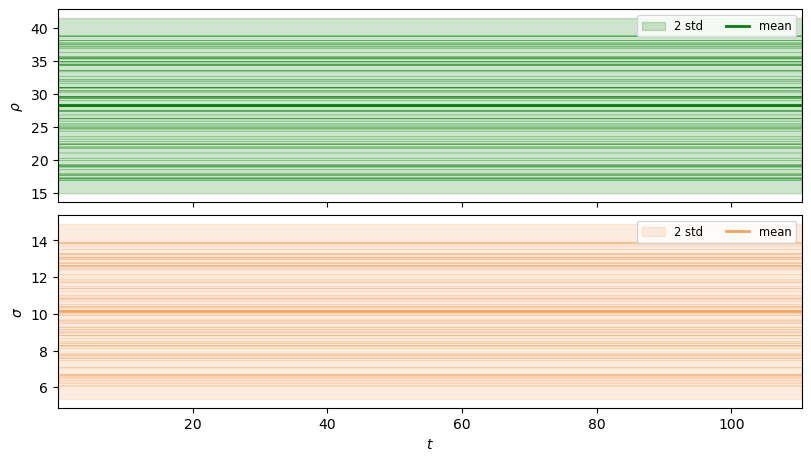

In [9]:

# Plot the parameters params
c = ['g', 'sandybrown', 'mediumpurple', 'cyan']

hist_p = ensemble.hist[:, -ensemble.Na:]
mean_p = np.mean(hist_p, axis=-1)
std_p = np.std(hist_p, axis=-1)

colors_alpha = ['green', 'sandybrown', [0.7, 0.7, 0.87], 'blue', 'red', 'gold', 'deepskyblue']

fig = plt.figure(figsize=(8, 4.5), layout="constrained")
axs = fig.subplots(ensemble.Na, 1, sharex='col')
if isinstance(axs, plt.Axes):
    axs = [axs]
    
for ii, ax, p, c in zip(range(len(axs)), axs, ensemble.est_a, colors_alpha):
    avg, s, all_h = [xx[:,ii] for xx in [mean_p, std_p, hist_p]]
    ax.fill_between(t_h, avg + 2*abs(s), avg - 2*abs(s), alpha=0.2, color=c, label='2 std')
    ax.plot(t_h, avg, color=c, label='mean', lw=2)
    ax.plot(t_h, all_h, color=c, lw=0.3, alpha=0.8)
    ax.legend(loc='upper right', fontsize='small', ncol=2)
    ax.set(ylabel=ensemble.alpha_labels[p])


axs[-1].set(xlabel='$t$', xlim=[ensemble.hist_t[0], ensemble.hist_t[-1]]);
        


# Introduction to create_ensemble function from "src.create" <a class="anchor" id="seventh"></a>
Wraps around <Model.init_ensemble> to also allow the definition of data assimilation parameters. This function will be used in the rest of the notebooks. 

In [10]:
from src.create import create_ensemble
ensemble = create_ensemble(model=Lorenz63,
                           est_a=['rho', 'sigma'],
                           std_a=dict(rho=[15., 30.], 
                                      sigma=[5, 13]),
                           std_psi=0.25, 
                           m=100
                           )



 ------------------ Lorenz63 Model Parameters ------------------ 
	 Nq = 3
	 beta = 2.666667
	 observe_dims = range(0, 3)
	 rho = 28.000000
	 sigma = 10.000000
	 t_lyap = 1.104240


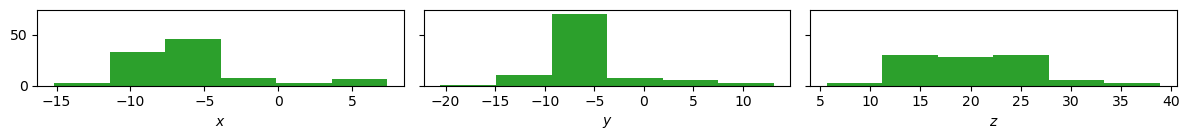

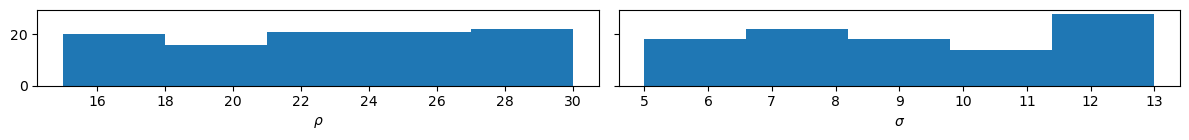

In [11]:
# Visualize the ensemble. 
# By default, the ensemble is initialized with uniform parameter distributions and Gaussian state variables.
from src.plot_results import plot_ensemble
ensemble.print_model_parameters()
plot_ensemble(ensemble)